<a href="https://colab.research.google.com/github/christopher-reed/tidytuesday/blob/master/2021/week_3/TidyTuesdayTate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages and Data

Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import seaborn as sns

Data

In [2]:
df_artwork = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-01-12/artwork.csv')
df_artists = pd.read_csv("https://github.com/tategallery/collection/raw/master/artist_data.csv")

# Wrangle

Step 1: Drop specific artists, handle NAs, handle character values, find what period each piece is from, and find the number of pieces from each period in each acquisition year.

In [3]:
# Drop works produced by JMW Turner (id 558). Doing this because he contributed 40,000 (!) pieces.
df_artwork_clean = df_artwork[df_artwork['artist'] != 'Turner, Joseph Mallord William']

# Drop na for year of creation and year of acquisition
df_artwork_clean = df_artwork_clean.dropna(axis = 0,
                                     subset = ['year', 'acquisitionYear'])

# Year to int (this will produce warning, but doesn't apply bc we're saving the column)
df_artwork_clean['year'] = df_artwork_clean['year'].astype(int)
df_artwork_clean['acquisitionYear'] = df_artwork_clean['acquisitionYear'].astype(int)

# Only need a few columns
df_artwork_clean = df_artwork_clean[['year', 'acquisitionYear']]

# Define function to conditionally create column
def find_period(x):

  """
  Function to label art based on the period it was created
  """

  if x <= 1800:
    return 'Pre-1800s'

  elif x > 1800 and x <= 1850:
    return '1800 - 1850'

  elif x > 1850 and x <= 1900:
    return '1850 - 1900'

  elif x > 1900 and  x <= 1925:
    return  '1900 - 1925'

  elif x > 1925 and x <= 1950:
    return '1925 - 1950'

  elif x > 1950 and x <= 1975:
    return '1950 - 1975'

  elif x > 1975 and x <= 2000:
    return '1975 - 2000'

  elif x > 2000:
    return '2000 - 2013'

# Apply above functions to year column
df_artwork_clean['period'] = df_artwork_clean['year'].apply(find_period)

# In each acquisition year, find the number of pieces from each period. Rename column.
df_artwork_clean_count = df_artwork_clean.groupby(['acquisitionYear', 'period']).count().reset_index().rename(columns = {'year':'n'})

# Check midpoint
df_artwork_clean_count.head()

,acquisitionYear,period,n
0,1823,Pre-1800s,1
1,1824,1800 - 1850,1
2,1824,Pre-1800s,1
3,1826,1800 - 1850,1
4,1826,Pre-1800s,3
...,...,...,...
741,2013,1925 - 1950,34
742,2013,1950 - 1975,133
743,2013,1975 - 2000,121
744,2013,2000 - 2013,161


Step 2: Within each acquisition year (level 0 index) what proportion of the art is from each period?

In [6]:
#################
## INDEX MAGIC ##
#################

# Create a multi index with acquisitionYear and period
df_artwork_indexed = df_artwork_clean_count.set_index(['acquisitionYear', 'period'])

# Within each acquisitionYear, there are not always all the periods.
# This line will make sure that for each acquisitionYear index, every period is present
# This will create NAs in column `n`
df_artwork_indexed = df_artwork_indexed.reindex(pd.MultiIndex.from_product(df_artwork_indexed.index.levels))

############
## WRANGLE##
############

# Fill NA with zero bc no art was acquired from that period
df_artwork_indexed['n'] = df_artwork_indexed['n'].fillna(0)

# find the cumulative sum of art from each period through all the acquisition years
df_artwork_indexed['n_cumsum'] = df_artwork_indexed.groupby(level=['period'])['n'].transform(pd.Series.cumsum)

# Within each acquisition year (level 0 index) what proportion of the art is from each period?
df_artwork_prop = df_artwork_indexed / df_artwork_indexed.groupby(level = 0).sum()

# Drop columns
df_artwork_prop = df_artwork_prop.drop(columns = 'n')

# Rename
df_artwork_prop = df_artwork_prop.rename(columns = {'n_cumsum':'prop'})

df_artwork_prop = df_artwork_prop.reset_index()

# Only focus on art from 1900 onward
df_artwork_prop = df_artwork_prop[df_artwork_prop['acquisitionYear'] >= 1900]

# Peep an entire acquisitionYear
df_artwork_prop.head(8)

,acquisitionYear,period,prop
504,1900,1800 - 1850,0.365060
505,1900,1850 - 1900,0.327711
506,1900,1900 - 1925,0.000000
507,1900,1925 - 1950,0.000000
508,1900,1950 - 1975,0.000000
509,1900,1975 - 2000,0.000000
510,1900,2000 - 2013,0.000000
511,1900,Pre-1800s,0.307229


# Plotting

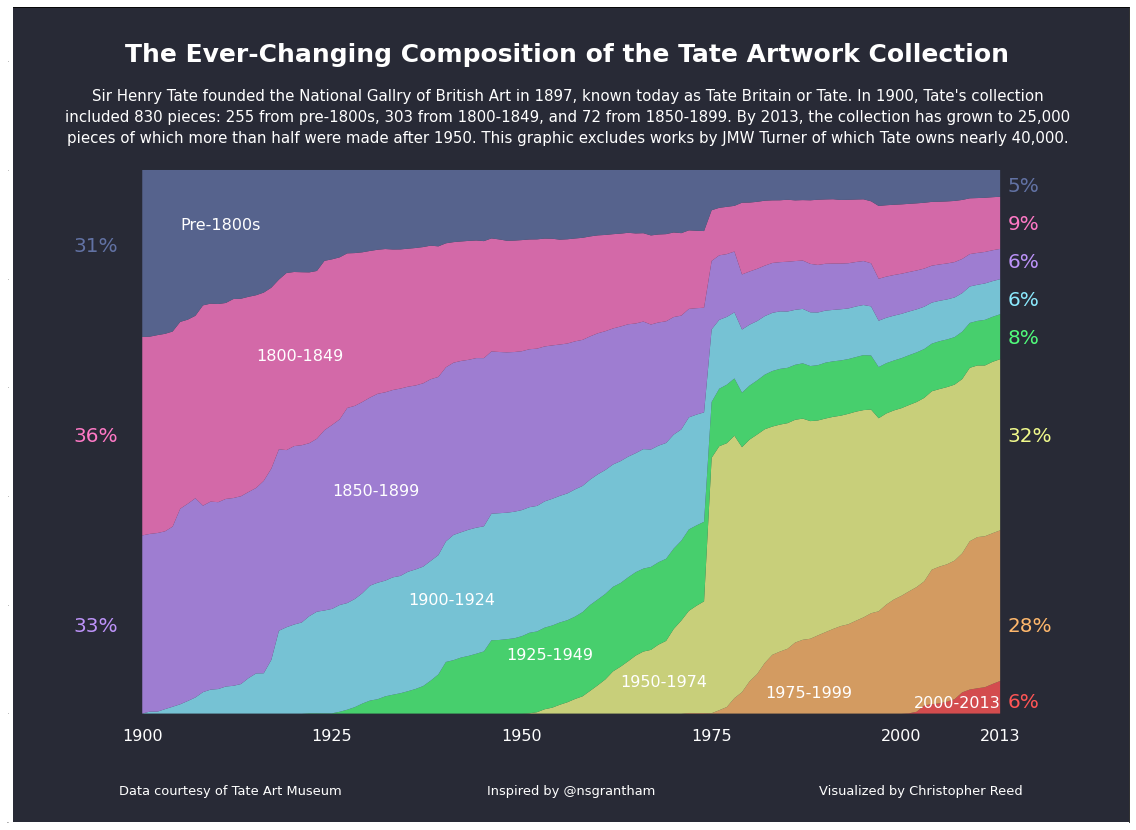

In [10]:
# Create fig and ax
fig, ax = plt.subplots(figsize = (20, 15))

# Use stackplot function
ax.stackplot(df_artwork_prop[df_artwork_prop['period'] == 'Pre-1800s']['acquisitionYear'],
              [df_artwork_prop[df_artwork_prop['period'] == '2000 - 2013']['prop'], df_artwork_prop[df_artwork_prop['period'] == '1975 - 2000']['prop'],
               df_artwork_prop[df_artwork_prop['period'] == '1950 - 1975']['prop'], df_artwork_prop[df_artwork_prop['period'] == '1925 - 1950']['prop'],
               df_artwork_prop[df_artwork_prop['period'] == '1900 - 1925']['prop'], df_artwork_prop[df_artwork_prop['period'] == '1850 - 1900']['prop'],
               df_artwork_prop[df_artwork_prop['period'] == '1800 - 1850']['prop'], df_artwork_prop[df_artwork_prop['period'] == 'Pre-1800s']['prop']],
             colors = ['#ff5555', '#ffb86c', '#f1fa8c', '#50fa7b', '#8be9fd', '#bd93f9', '#ff79c6', '#6272a4'],
              alpha=0.8)

###################
## TEXT & LABELS ##
###################

# In 1900
ax.text(1891, 0.15, '33%', color = '#bd93f9', fontsize = 20)
ax.text(1891, 0.50, '36%', color = '#ff79c6', fontsize = 20)
ax.text(1891, 0.85, '31%', color = '#6272a4', fontsize = 20)

# In 2013
ax.text(2014, 0.01, '6%', color = '#ff5555', fontsize = 20)
ax.text(2014, 0.15, '28%', color = '#ffb86c', fontsize = 20)
ax.text(2014, 0.50, '32%', color = '#f1fa8c', fontsize = 20)
ax.text(2014, 0.68, '8%', color = '#50fa7b', fontsize = 20)
ax.text(2014, 0.75, '6%', color = '#8be9fd', fontsize = 20)
ax.text(2014, 0.82, '6%', color = '#bd93f9', fontsize = 20)
ax.text(2014, 0.89, '9%', color = '#ff79c6', fontsize = 20)
ax.text(2014, 0.96, '5%', color = '#6272a4', fontsize = 20)

# Period labels
ax.text(1905, 0.89, 'Pre-1800s', color = 'white', fontsize = 16)
ax.text(1915, 0.65, '1800-1849', color = 'white', fontsize = 16)
ax.text(1925, 0.40, '1850-1899', color = 'white', fontsize = 16)
ax.text(1935, 0.20, '1900-1924', color = 'white', fontsize = 16)
ax.text(1948, 0.10, '1925-1949', color = 'white', fontsize = 16)
ax.text(1963, 0.05, '1950-1974', color = 'white', fontsize = 16)
ax.text(1982, 0.03, '1975-1999', color = 'white', fontsize = 16)
ax.text(2013, 0.01, '2000-2013', color = 'white', fontsize = 16, ha = 'right')

# Title
ax.text(1956, 1.2,
        'The Ever-Changing Composition of the Tate Artwork Collection', 
        color = 'white',
        fontsize = 25,
        weight = 'bold',
        ha = 'center')

# Description
ax.text(1956, 1.05,
"""Sir Henry Tate founded the National Gallry of British Art in 1897, known today as Tate Britain or Tate. In 1900, Tate\'s collection
included 830 pieces: 255 from pre-1800s, 303 from 1800-1849, and 72 from 1850-1899. By 2013, the collection has grown to 25,000
pieces of which more than half were made after 1950. This graphic excludes works by JMW Turner of which Tate owns nearly 40,000.""",
color = 'white',
fontsize = 15,
linespacing = 1.5,
ha = 'center')


# Credits
ax.text(1897, -0.15,
        'Data courtesy of Tate Art Museum',
        color = 'white',
        fontsize = 13)

ax.text(1956.5, -0.15,
        'Inspired by @nsgrantham',
        color = 'white',
        fontsize = 13,
        ha = 'center')

ax.text(2016, -0.15,
        'Visualized by Christopher Reed',
        color = 'white',
        fontsize = 13,
        ha = 'right')

######################
## TICKS AND SPINES ##
######################

# Set x-axis at y = 0 instead of bottom of figure
ax.spines['bottom'].set_position('zero')

# X-tick labels, size, and color
ax.set_xticks([1900, 1925, 1950, 1975, 2000, 2013])
ax.tick_params(axis = 'x', length = 0, labelsize = 16, labelcolor = 'white', pad = 15)

# Hide all spines and y-axis ticks/labels
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis = 'y', labelsize = 0, length = 0)

#################
## AXIS LIMITS ##
#################

ax.set_ylim(bottom =-0.2, top = 1.3)
ax.set_xlim(left = 1883, right = 2030)

###############
## FACECOLOR ##
###############

ax.set_facecolor('#282a36')

#################
## SAVE FIGURE ##
#################

plt.savefig('Tate Art', facecolor = '#282a36', bbox_inches = 'tight')